# Summary

## This notebook extends the log and XGBoost model notebooks.

In this notebook, a Multi-Agent model is used to predict loan defaults, with a primary focus on reducing false negatives—accurately identifying clients who will default on their loans. 

While there is less emphasis on reducing false positives (predicting defaults for clients who do not actually default), the Multi-Agent model aims to provide a more reliable assessment of loan applications.

Overall, the model's accuracy and precision decreased by 3%, but recall increased significantly by 31%, improving the detection of actual defaulters.

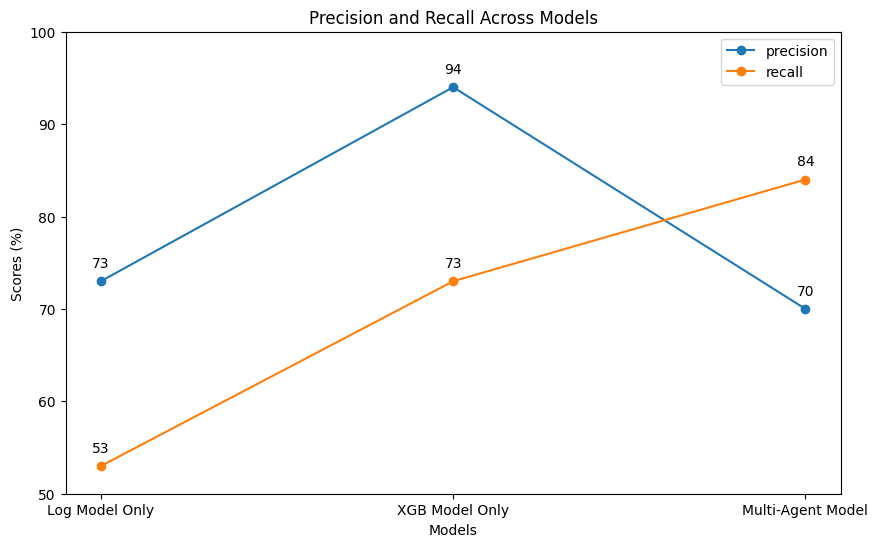

In [3]:
credit_model.visualize_performance()

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
import xgboost as xgb

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

There are 32581 rows and 12 features.
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
Logistic Regression Model Evaluation (PCA Log Model 1):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8195
           1       0.63      0.53      0.58      2230

    accuracy                           0.83     10425
   macro avg       0.76      0.72      0.74     10425
weighted avg       0.83      0.83      0.83     10425

XGBoost Model Evaluation (Multi-Agent Model):
              precision    recall  f1-score   support

        

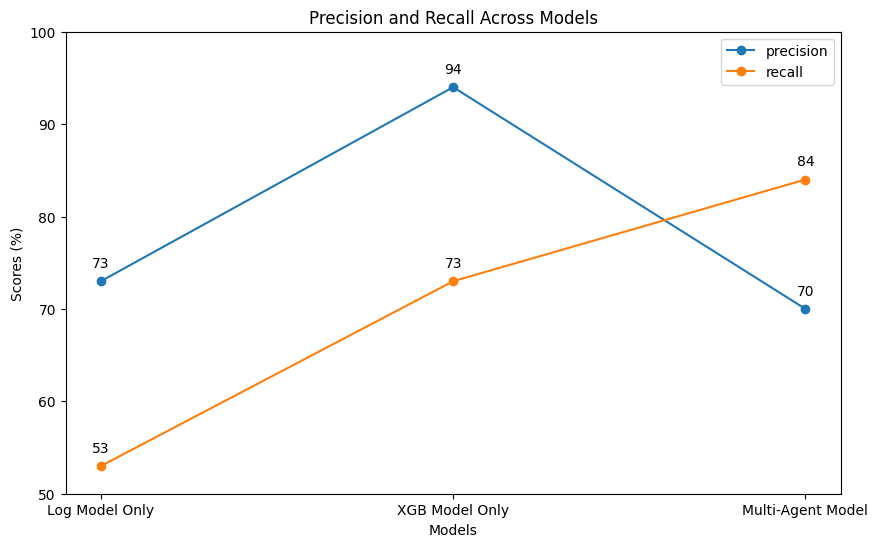

In [19]:
class CreditRiskModel:
    def __init__(self, data_path, n_components=14):
        self.data_path = data_path
        self.data = None
        self.cleaned_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred_thres = None
        self.log_preds = None
        self.scaler = MinMaxScaler(feature_range=[0, 1])
        self.pca = PCA(n_components=n_components)
        self.log_model = LogisticRegression()
        self.xgb_model = xgb.XGBClassifier()
        self.metrics = {'precision': [73, 94], 'recall': [53, 73]}  # Add provided metrics here
    
    
    def load_data(self):
        self.data = pd.read_csv(self.data_path)
        print(f"There are {self.data.shape[0]} rows and {self.data.shape[1]} features.")
        print(self.data.dtypes)
        return self.data
    
    
    def clean_data(self):
        self.data = self.data.rename(
            columns={"cb_person_default_on_file": "default_hist",
                     "cb_person_cred_hist_length": "cr_hist_len"})
        
        # Handle missing values
        self.data['person_emp_length'].fillna(self.data['person_emp_length'].median(), inplace=True)
        self.data['loan_int_rate'].fillna(self.data['loan_int_rate'].median(), inplace=True)
        
        # Remove outliers
        self.cleaned_data = self.data[self.data['person_age'] <= 100]

        # One-hot encode categorical variables
        num_col = self.cleaned_data.select_dtypes(exclude='object')
        char_col = self.cleaned_data.select_dtypes(include='object')
        encoded_char_col = pd.get_dummies(char_col)
        self.cleaned_data = pd.concat([num_col, encoded_char_col], axis=1)
        
        return self.cleaned_data
    
    
    def preprocess_data(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Scale features
        data_rescaled = self.scaler.fit_transform(X)

        # Apply PCA
        pca_dataset = self.pca.fit_transform(data_rescaled)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(pca_dataset, Y, random_state=2020, test_size=0.32)
    
    
    def train_log_model(self):
        self.log_model.fit(self.X_train, np.ravel(self.y_train))
        y_pred_proba = self.log_model.predict_proba(self.X_test)[:, 1]
        pca_predict_log = pd.DataFrame(y_pred_proba, columns=['prob_default'])
        self.y_pred_thres = pca_predict_log['prob_default'].apply(lambda x: 1 if x > 0.36 else 0)
        self.log_preds = pd.DataFrame(self.y_pred_thres, columns=['log_preds'])
        
        print("Logistic Regression Model Evaluation (PCA Log Model 1):")
        print(classification_report(self.y_test, self.y_pred_thres))
        
        # Calculate and store precision and recall
        precision = precision_score(self.y_test, self.y_pred_thres)
        recall = recall_score(self.y_test, self.y_pred_thres)

        
    def preprocess_for_xgb(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Add log_preds as a feature and convert to numerical type
        log_preds_numerical = self.log_preds.astype(int)  # Ensure log_preds is numerical
        X = pd.concat([X.reset_index(drop=True), log_preds_numerical.reset_index(drop=True)], axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, random_state=2020, test_size=0.30)
    
    
    def train_xgb_model(self):
        self.xgb_model.fit(self.X_train, np.ravel(self.y_train))
    
    
    def evaluate_xgb_model(self, log_threshold=0.36):
        predict_xgb = self.xgb_model.predict_proba(self.X_test)[:, 1]
        predict_xgb_prob = pd.DataFrame(predict_xgb, columns=['Default Probability'])
        y_pred_thres = predict_xgb_prob['Default Probability'].apply(lambda x: 1 if x > log_threshold else 0)
        
        print("XGBoost Model Evaluation (Multi-Agent Model):")
        print(classification_report(self.y_test, y_pred_thres))
        
        # Calculate and store precision and recall
        precision = precision_score(self.y_test, y_pred_thres)
        recall = recall_score(self.y_test, y_pred_thres)
        self.metrics['precision'].append(round(precision * 100))
        self.metrics['recall'].append(round(recall * 100))
    
    
    def visualize_performance(self):
        models = ['Log Model Only', 'XGB Model Only', 'Multi-Agent Model']
        
        plt.figure(figsize=(10, 6))

        for metric in self.metrics:
            values = self.metrics[metric]
            plt.plot(models, values, marker='o', label=metric)
            for i, txt in enumerate(values):
                plt.annotate(f'{txt}', (models[i], values[i]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.xlabel('Models')
        plt.ylabel('Scores (%)')
        plt.title('Precision and Recall Across Models')
        plt.legend()
        plt.ylim(50, 100)
        plt.show()
        

        
# Workflow
credit_model = CreditRiskModel('credit_risk_dataset.csv')
credit_model.load_data()
credit_model.clean_data()
credit_model.preprocess_data()
credit_model.train_log_model()
credit_model.preprocess_for_xgb()
credit_model.train_xgb_model()
credit_model.evaluate_xgb_model(log_threshold=0.17)
credit_model.visualize_performance()


# Access the final predictions for further use
final_predictions = credit_model.y_pred_thres


In [20]:
#0.20
credit_model.evaluate_xgb_model(log_threshold=0.20)

XGBoost Model Evaluation (Multi-Agent Model):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7684
           1       0.74      0.82      0.78      2089

    accuracy                           0.90      9773
   macro avg       0.84      0.87      0.86      9773
weighted avg       0.90      0.90      0.90      9773



In [5]:
#0.15
credit_model.evaluate_xgb_model(log_threshold=0.15)

XGBoost Model Evaluation (Multi-Agent Model):
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7684
           1       0.66      0.86      0.75      2089

    accuracy                           0.88      9773
   macro avg       0.81      0.87      0.83      9773
weighted avg       0.89      0.88      0.88      9773



In [6]:
final_predictions

0        1
1        0
2        0
3        0
4        0
        ..
10420    1
10421    0
10422    0
10423    0
10424    1
Name: prob_default, Length: 10425, dtype: int64

In [12]:
CreditRiskModel.y_test()

AttributeError: type object 'CreditRiskModel' has no attribute 'y_test'

There are 32581 rows and 12 features.
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
Logistic Regression Model Evaluation (PCA Log Model 1):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8195
           1       0.63      0.53      0.58      2230

    accuracy                           0.83     10425
   macro avg       0.76      0.72      0.74     10425
weighted avg       0.83      0.83      0.83     10425

XGBoost Model Evaluation (Multi-Agent Model):
              precision    recall  f1-score   support

        

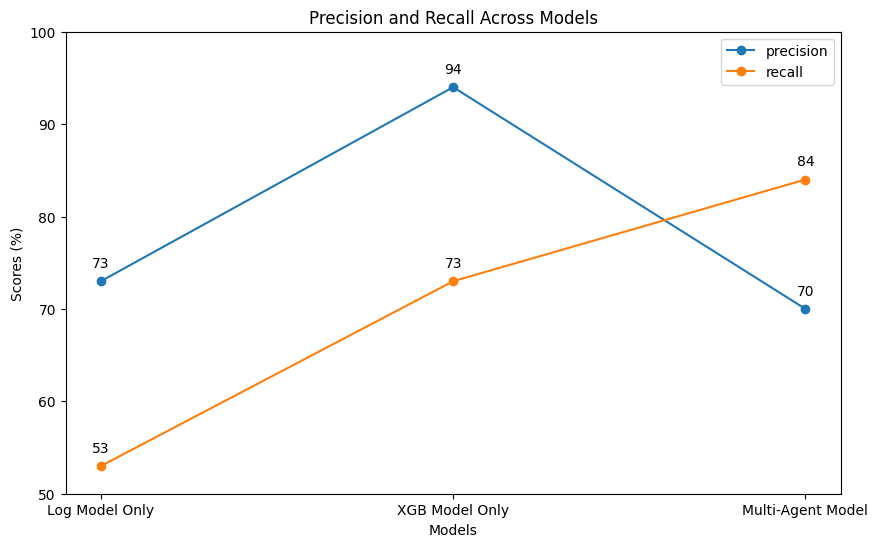

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
import xgboost as xgb

class CreditRiskModel:
    def __init__(self, data_path, n_components=14):
        self.data_path = data_path
        self.data = None
        self.cleaned_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred_thres = None
        self.log_preds = None
        self.scaler = MinMaxScaler(feature_range=[0, 1])
        self.pca = PCA(n_components=n_components)
        self.log_model = LogisticRegression()
        self.xgb_model = xgb.XGBClassifier()
        self.metrics = {'precision': [73, 94], 'recall': [53, 73]}  # Add provided metrics here
    
    def load_data(self):
        self.data = pd.read_csv(self.data_path)
        print(f"There are {self.data.shape[0]} rows and {self.data.shape[1]} features.")
        print(self.data.dtypes)
        return self.data
    
    def clean_data(self):
        self.data = self.data.rename(
            columns={"cb_person_default_on_file": "default_hist",
                     "cb_person_cred_hist_length": "cr_hist_len"})
        
        # Handle missing values
        self.data['person_emp_length'].fillna(self.data['person_emp_length'].median(), inplace=True)
        self.data['loan_int_rate'].fillna(self.data['loan_int_rate'].median(), inplace=True)
        
        # Remove outliers
        self.cleaned_data = self.data[self.data['person_age'] <= 100]

        # One-hot encode categorical variables
        num_col = self.cleaned_data.select_dtypes(exclude='object')
        char_col = self.cleaned_data.select_dtypes(include='object')
        encoded_char_col = pd.get_dummies(char_col)
        self.cleaned_data = pd.concat([num_col, encoded_char_col], axis=1)
        
        return self.cleaned_data
    
    def preprocess_data(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Scale features
        data_rescaled = self.scaler.fit_transform(X)

        # Apply PCA
        pca_dataset = self.pca.fit_transform(data_rescaled)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(pca_dataset, Y, random_state=2020, test_size=0.32)
    
    def train_log_model(self):
        self.log_model.fit(self.X_train, np.ravel(self.y_train))
        y_pred_proba = self.log_model.predict_proba(self.X_test)[:, 1]
        pca_predict_log = pd.DataFrame(y_pred_proba, columns=['prob_default'])
        self.y_pred_thres = pca_predict_log['prob_default'].apply(lambda x: 1 if x > 0.36 else 0)
        self.log_preds = pd.DataFrame(self.y_pred_thres, columns=['log_preds'])
        
        print("Logistic Regression Model Evaluation (PCA Log Model 1):")
        print(classification_report(self.y_test, self.y_pred_thres))
        
        # Calculate and store precision and recall
        precision = precision_score(self.y_test, self.y_pred_thres)
        recall = recall_score(self.y_test, self.y_pred_thres)
    
    def preprocess_for_xgb(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Add log_preds as a feature and convert to numerical type
        log_preds_numerical = self.log_preds.astype(int)  # Ensure log_preds is numerical
        X = pd.concat([X.reset_index(drop=True), log_preds_numerical.reset_index(drop=True)], axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, random_state=2020, test_size=0.30)
    
    def train_xgb_model(self):
        self.xgb_model.fit(self.X_train, np.ravel(self.y_train))
    
    def evaluate_xgb_model(self, log_threshold=0.36):
        predict_xgb = self.xgb_model.predict_proba(self.X_test)[:, 1]
        predict_xgb_prob = pd.DataFrame(predict_xgb, columns=['Default Probability'])
        y_pred_thres = predict_xgb_prob['Default Probability'].apply(lambda x: 1 if x > log_threshold else 0)
        
        print("XGBoost Model Evaluation (Multi-Agent Model):")
        print(classification_report(self.y_test, y_pred_thres))
        
        # Calculate and store precision and recall
        precision = precision_score(self.y_test, y_pred_thres)
        recall = recall_score(self.y_test, y_pred_thres)
        self.metrics['precision'].append(round(precision * 100))
        self.metrics['recall'].append(round(recall * 100))
    
    def visualize_performance(self):
        models = ['Log Model Only', 'XGB Model Only', 'Multi-Agent Model']
        
        plt.figure(figsize=(10, 6))

        for metric in self.metrics:
            values = self.metrics[metric]
            plt.plot(models, values, marker='o', label=metric)
            for i, txt in enumerate(values):
                plt.annotate(f'{txt}', (models[i], values[i]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.xlabel('Models')
        plt.ylabel('Scores (%)')
        plt.title('Precision and Recall Across Models')
        plt.legend()
        plt.ylim(50, 100)
        plt.show()
    
    def predict_new_data(self, new_data_path, log_threshold=0.36):
        
        new_data = pd.read_csv(new_data_path)
 
        new_data = new_data.rename(
            columns={"cb_person_default_on_file": "default_hist",
                     "cb_person_cred_hist_length": "cr_hist_len"})
        
        # Handle missing values
        new_data['person_emp_length'].fillna(new_data['person_emp_length'].median(), inplace=True)
        new_data['loan_int_rate'].fillna(new_data['loan_int_rate'].median(), inplace=True)
        
        # Remove outliers
        new_data = new_data[new_data['person_age'] <= 100]

        # One-hot encode categorical variables
        num_col = new_data.select_dtypes(exclude='object')
        char_col = new_data.select_dtypes(include='object')
        encoded_char_col = pd.get_dummies(char_col)
        new_data_cleaned = pd.concat([num_col, encoded_char_col], axis=1)
        
        # Ensure the columns match between new data and original data
        missing_cols = set(self.cleaned_data.columns) - set(new_data_cleaned.columns)
        for col in missing_cols:
            new_data_cleaned[col] = 0
        new_data_cleaned = new_data_cleaned[self.cleaned_data.columns]
        
        # Remove Prediction Column
        try:
            new_data_cleaned = new_data_cleaned.drop('loan_status',axis=1)
        
        except:
            print("No loan status column.")
        
        # Scale features
        data_rescaled = self.scaler.transform(new_data_cleaned)
        
        # Apply PCA
        pca_dataset = self.pca.transform(data_rescaled)
        
        # Predict using logistic regression model
        log_preds_proba = self.log_model.predict_proba(pca_dataset)[:, 1]
        log_preds = pd.DataFrame(log_preds_proba, columns=['log_preds'])
        
        # Add log_preds as a feature for the XGBoost model
        new_data_for_xgb = pd.concat([new_data_cleaned.reset_index(drop=True), log_preds.reset_index(drop=True)], axis=1)
        
        # Predict using XGBoost model
        xgb_preds_proba = self.xgb_model.predict_proba(new_data_for_xgb)[:, 1]
        xgb_preds = pd.DataFrame(xgb_preds_proba, columns=['Default Probability'])
        xgb_preds_thres = xgb_preds['Default Probability'].apply(lambda x: 1 if x > log_threshold else 0)
        
        return xgb_preds_thres

        
# Workflow
credit_model = CreditRiskModel('credit_risk_dataset.csv')
credit_model.load_data()
credit_model.clean_data()
credit_model.preprocess_data()
credit_model.train_log_model()
credit_model.preprocess_for_xgb()
credit_model.train_xgb_model()
credit_model.evaluate_xgb_model(log_threshold=0.17)
credit_model.visualize_performance()

# Access the final predictions for further use
final_predictions = credit_model.y_pred_thres


In [30]:
# Predict with new data
new_predictions = credit_model.predict_new_data('credit_risk_dataset.csv')
print(new_predictions)


0        1
1        0
2        1
3        1
4        1
        ..
32571    0
32572    0
32573    1
32574    0
32575    0
Name: Default Probability, Length: 32576, dtype: int64


In [37]:
data.shape[0]

32581

In [42]:
data = pd.read_csv("credit_risk_dataset.csv")
data['y_pred'] = new_predictions
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,y_pred
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,1.0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,1.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,1.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,1.0


In [41]:




pivot_table = pd.crosstab(data['loan_status'], new_predictions, rownames=['loan_status'], colnames=['new_predictions'], margins=True)/num_rows

pivot_table

new_predictions,0,1,All
loan_status,,,
0,0.650011,0.131703,0.781713
1,0.156594,0.061539,0.218133
All,0.806605,0.193241,0.999847


In [58]:
num_rows = data.shape[0]

# group values bby history, status, and the values are y_pred
group_hst_status_pred_sum = data.groupby(['cb_person_default_on_file', 'loan_status'])['y_pred'].sum()
group_hst_status_pred_sum = pd.DataFrame(grouped_data)
group_hst_status_pred_sum

y_pred
cb_person_default_on_file loan_status        
N                         0            3684.0
                          1            1464.0
Y                         0             607.0
                          1             541.0

In [59]:
# Create pivot table where the values are the sum of pred values, {0,1}
pivot_table = group_hst_status_pred_sum.reset_index().pivot(index='cb_person_default_on_file', columns='loan_status', values='y_pred')
pivot_table / num_rows

loan_status,0,1
cb_person_default_on_file,,
N,0.113072,0.044934
Y,0.018630,0.016605
